In [1]:
#import necessary packages

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
print(tf.__version__)
from keras.regularizers import l2
from sklearn import metrics
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category=FutureWarning)

1.14.0


Using TensorFlow backend.


In [2]:
from google.colab import files


uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

Saving data.csv to data.csv
User uploaded file "data.csv" with length 320356499 bytes


In [3]:
import io
df = pd.read_csv(io.BytesIO(uploaded['data.csv']))# Dataset is now stored in a Pandas Dataframe

/usr/local/lib/python3.6/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [0]:
# Models on Psychiatyric

#The columns that start with q correspond to question numbers

questions_filter = [col for col in df if col.startswith('q')]

questions_filter.append('psychiatric')
df_questions=df[questions_filter]
df_questions.psychiatric.isna().sum()


len(df_questions.columns)

#Removing Duplicates that might corrupt the model


questions_filter.pop()

df_q=df_questions.drop_duplicates(subset=questions_filter,keep=False)


df_q=df_q.sample(frac=1)
df_p=df_q.psychiatric
df_q=df_q.drop('psychiatric',axis=1)
df_p=df_p.astype('int')


X_train, X_val, y_train, y_val = train_test_split(df_q, df_p, test_size=0.2, random_state=42)

In [0]:
#We use l2 regularization to prevent overfitting
def Build_Model():
    model=keras.Sequential([
       
        layers.Dense(128,activation=tf.nn.relu,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01), input_shape=[len(X_train.keys())]),
        layers.Dense(64,activation=tf.nn.relu,kernel_regularizer=l2(0.01), bias_regularizer=l2(0.01)),
        layers.Dense(1,activation=tf.nn.sigmoid)
    ])


    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['binary_accuracy'])
    return model

In [55]:
model=Build_Model()
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_37 (Dense)             (None, 128)               12288     
_________________________________________________________________
dense_38 (Dense)             (None, 64)                8256      
_________________________________________________________________
dense_39 (Dense)             (None, 1)                 65        
Total params: 20,609
Trainable params: 20,609
Non-trainable params: 0
_________________________________________________________________


In [56]:
EPOCHS=20

early_stop=keras.callbacks.EarlyStopping(monitor='val_loss',patience=4)
history=model.fit(X_train,y_train,epochs=EPOCHS,validation_split=0.2,verbose=1,callbacks=[early_stop])


Train on 210790 samples, validate on 52698 samples
Epoch 1/20
210790/210790 [==============================] - 24s 113us/sample - loss: 0.2129 - binary_accuracy: 0.9567 - val_loss: 0.1754 - val_binary_accuracy: 0.9581
Epoch 2/20
210790/210790 [==============================] - 23s 110us/sample - loss: 0.1788 - binary_accuracy: 0.9569 - val_loss: 0.1731 - val_binary_accuracy: 0.9581
Epoch 3/20
210790/210790 [==============================] - 24s 112us/sample - loss: 0.1782 - binary_accuracy: 0.9569 - val_loss: 0.1752 - val_binary_accuracy: 0.9581
Epoch 4/20
210790/210790 [==============================] - 23s 110us/sample - loss: 0.1775 - binary_accuracy: 0.9569 - val_loss: 0.1727 - val_binary_accuracy: 0.9581
Epoch 5/20
210790/210790 [==============================] - 23s 110us/sample - loss: 0.1775 - binary_accuracy: 0.9569 - val_loss: 0.1722 - val_binary_accuracy: 0.9581
Epoch 6/20
210790/210790 [==============================] - 23s 110us/sample - loss: 0.1773 - binary_accuracy: 0.9

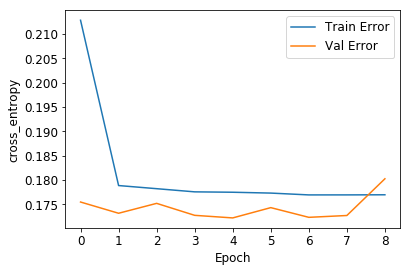

<Figure size 432x288 with 0 Axes>

In [57]:


def plot_history(history):
    hist=pd.DataFrame(history.history)
    hist['epoch']=history.epoch
    
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('cross_entropy')
    plt.plot(hist['epoch'],hist['loss'],label='Train Error')
    plt.plot(hist['epoch'],hist['val_loss'], label='Val Error')
    plt.legend()
    
    plt.figure()
    
plot_history(history)
    



In [0]:
test_predictions=model.predict_classes(X_val)
test_predictions_probability=model.predict(X_val)

In [59]:
print('Confusion matrix:')
print(metrics.confusion_matrix(y_val, test_predictions))
confusion=metrics.confusion_matrix(y_val, test_predictions)
TP = confusion[1, 1]
TN = confusion[0, 0]
FP = confusion[0, 1]
FN = confusion[1, 0]

#accuracy
print('Accuracy:')
print((TP + TN) / float(TP + TN + FP + FN))
#print(metrics.accuracy_score(y_test, test_predictions))

Confusion matrix:
[[63115     0]
 [ 2757     0]]
Accuracy:
0.9581461015302405


In [60]:
metrics.roc_auc_score(y_val, test_predictions_probability)

0.6470266936780599

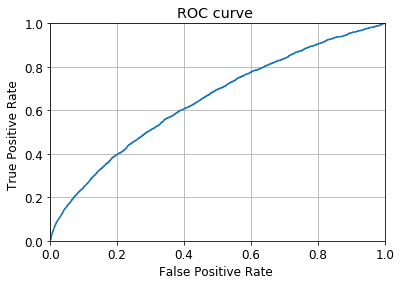

In [62]:


fpr, tpr, thresholds = metrics.roc_curve(y_val, test_predictions_probability)

plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.rcParams['font.size'] = 12
plt.title('ROC curve ')
plt.xlabel('False Positive Rate ')
plt.ylabel('True Positive Rate ')
plt.grid(True)

